In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 

In [68]:
node_per_row = 21
Nnodes = node_per_row*node_per_row
element_per_row = node_per_row-1
Nelements = (element_per_row)*(element_per_row)
nodes = np.zeros((Nnodes, 2))
barycenters = np.zeros((Nelements,2)) 


for n in range(Nnodes):
    i = int(n/node_per_row)
    j = (n%node_per_row)
    nodes[n,1] = 0. + i*(1./element_per_row) 
    nodes[n,0] = 0. + j*(1./element_per_row)

elements = []
for i in range(element_per_row):
    for j in range(element_per_row):
        elem = []
        # order nodes counter-clockwise
        elem.append(i*node_per_row + j)
        elem.append((i+1)*node_per_row + j)
        elem.append((i+1)*node_per_row + (j+1))
        elem.append(i*node_per_row + (j+1))
        elements.append(elem)
        barycenters[i*(element_per_row)+j,1] = (i+0.5)*(1./element_per_row)
        barycenters[i*(element_per_row)+j,0] = (j+0.5)*(1./element_per_row)

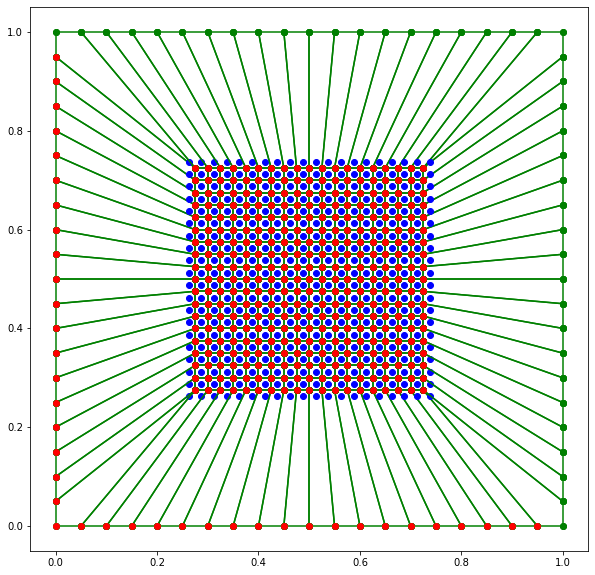

In [70]:
#a look at the primal mesh 
fig, ax  = plt.subplots(figsize = (10,10))
for i in range (Nelements):
    quad = elements[i]
    for j in range(4): 
        start = j
        end = (j+1)%4
        xx  = (nodes[quad[start], 0], nodes[quad[end],0])
        yy  = (nodes[quad[start], 1], nodes[quad[end],1])
        edge= ax.plot(xx,yy, 'go-')
    corner = ax.plot(nodes[quad[0]][0], nodes[quad[0]][1],'ro')
    bary= ax.plot(barycenters[i][0], barycenters[i][1],'bo')

In [60]:
#need to mark nodes on the boundary and the interface
bnd_marker = np.zeros(Nnodes)
for i in range (Nnodes):
    if nodes[i,1]==0.:
        bnd_marker[i] = 1
    elif nodes [i,0]==1.:
        bnd_marker[i] = 2
    elif nodes[i,1]==1.:
        bnd_marker[i] = 3
    elif nodes [i,0]==0.:
        bnd_marker[i] = 4
    else:
        bnd_marker[i] = 0
    if nodes[i,0]==0.5:
        bnd_marker[i] = -1 #interface

        
for i in range (Nnodes):
    x,y = nodes[i, 0], nodes[i,1]
    if y==0.:
        bnd_marker[i] = 1
    elif y==1.:
        bnd_marker[i] = 3 #need the point (0.,0.5) and (1.,1.5) to be recognized on the boundary

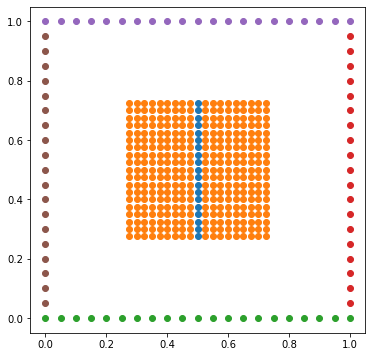

In [71]:
fig, ax = plt.subplots(figsize = (6,6))

for i in range(6):
   mask = (bnd_marker == i-1)
   bnd = nodes[mask,:]
   bndline = ax.scatter(bnd[:,0], bnd[:,1])

In [32]:
#DEFORMATION1: random displacement (TO INDUCE INSTABILITY)

#we can displace the internal nodes inside a circle of radius 0.5*(1./element_per_row)

for n in range(Nnodes):
    if (bnd_marker[n]==0):
        dx = (np.random.rand()-0.5)*0.8*(1./element_per_row)
        dy = (np.random.rand()-0.5)*0.8*(1./element_per_row)
        nodes[n]= nodes[n] + [dx,dy]

In [69]:
#DEFORMATION2: concentration at the centre

for n in range(Nnodes):
    if (bnd_marker[n]<1):
        nodes[n][0] = 0.5 - 0.5*(0.5-nodes[n][0])
        nodes[n][1] = 0.5 - 0.5*(0.5-nodes[n][1]) 
for n in range(Nelements):
        barycenters[n][0] = 0.5 - 0.5*(0.5-barycenters[n][0]) 
        barycenters[n][1] = 0.5 - 0.5*(0.5-barycenters[n][1])     

In [22]:
#need to build node2node connectivity (neighbours)
#need to build node2element connectivity (near_cells)

neighbours = [[]]*Nnodes
near_cells = [[]]*Nnodes
for i in range (Nelements):
    elem = elements[i]
    for j in range(4):
        # fill near_cells
        if (near_cells[elem[j]]==[]):
            near_cells[elem[j]] = [i]
        else:
            near_cells[elem[j]].append(i)
        # fill neighbours 
        for k in (1,2,3):
            ind = (j+k)%4 #cyclic index
            if (neighbours[elem[j]]==[]):
                neighbours[elem[j]] =[elem[ind]]
            elif not(elem[ind] in neighbours[elem[j]]):
                neighbours[elem[j]].append(elem[ind])

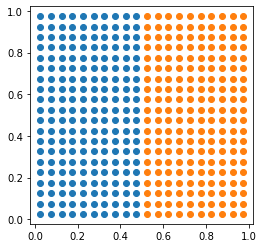

In [34]:
#interface along diagonal, sigma selected according to where barycenter falls
sigma1 = 0.1
sigma2 = 1
mask = (barycenters[:,0]<0.5)
sigma = np.zeros((Nelements))
sigma[mask] = sigma1
sigma[mask[:]==False] = sigma2

fig, ax = plt.subplots(figsize = (4,4))
pt1 = ax.scatter(barycenters[mask,0], barycenters[mask,1])
pt2= ax.scatter(barycenters[mask[:] == False,0], barycenters[mask[:]==False,1])

In [72]:
normal = np.zeros((Nelements, 4,2))
rot = np.array([[0,1],[-1,0]])

#fig, ax = plt.subplots(figsize = (20,20))

#calculate normals
for k in range(Nelements):
    elem = elements[k]
    #loop over the edges
    for i in range(4):
        j = (i+1)%4
        edge = nodes[elem[j]]-nodes[elem[i]]
        edge_bary = 0.5*(nodes[elem[j]]+nodes[elem[i]])
        #ax.plot([nodes[elem[j]][0],nodes[elem[i]][0]], [nodes[elem[j]][1],nodes[elem[i]][1]],'r-')
        edge = edge[0:2] #only components in xy plane
        normal[k,i,:]= np.dot(rot,edge)
        #ax.arrow(edge_bary[0], edge_bary[1], -normal[k,i,0], -normal[k,i,1])

omega = [[]]*Nnodes
m_T = np.zeros((Nelements))

#calculate omega_ij
#loop over elements
for k in range(Nelements):
    elem = elements[k]
    #loop over nodes
    for i in range(4):
       #loop over neighbours 
       for jj in (1,2,3):
            j = (i+jj)%4
            e_avg_i = -0.5*(normal[k,i,:] + normal[k,(i-1)%4,:])
            e_avg_j = -0.5*(normal[k,j,:] + normal[k,(j-1)%4,:])
            #area calculation (trivial for quads)
            m_T [k]= (1./element_per_row)*(1./element_per_row)
            index_j = [n for n,x in enumerate(neighbours[elem[i]]) if x == elem[j]][0]
            if (omega[elem[i]]==[]):
                omega[elem[i]]=[0.]
            while (len(omega[elem[i]])<(index_j+1)):
                omega[elem[i]].append(0.)
            #print (sigma[k],m_T[k], e_avg_i,e_avg_j)
            omega[elem[i]][index_j] = omega[elem[i]][index_j] - sigma[k]/m_T[k]*np.dot(e_avg_i,e_avg_j)

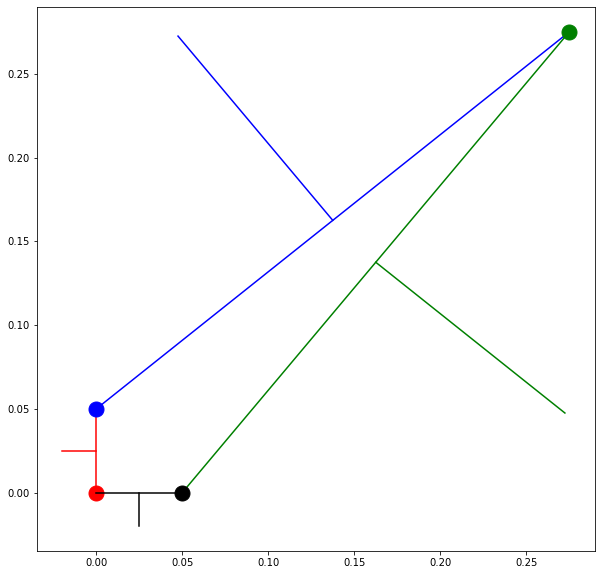

In [73]:
#check ordering
fig,ax = plt.subplots(figsize = (10,10))
for i in range(1):
    colors = ['r', 'b', 'g', 'k']
    nelem = 0
    elem = elements[nelem]
    for n in range(4):
        dot = ax.plot(nodes[elem[n]][0], nodes[elem[n]][1], colors[n], markersize=15, marker ='o')
        tri = ax.plot([nodes[elem[n],0],nodes[elem[(n+1)%4],0]], [nodes[elem[n],1],nodes[elem[(n+1)%4],1]],colors[n])
        edge_bary = 0.5*(nodes[elem[(n)%4]]+nodes[elem[(n+1)%4]])
        norm = ax.plot([edge_bary[0],edge_bary[0]- 0.4*normal[0,n,0]], 
                 [edge_bary[1],edge_bary[1] - 0.4*normal[0,n,1]], colors[n])
        plbary = ax.plot(barycenters[nelem,0], barycenters[nelem,1])

need to build $\omega_{ij}$ (for the moment without stabilization):

- loop over the elements
- calculate the normals and the averages
- from each element 6 contributions to the omega_ij


In [9]:
#quadrature over a segment: Simpson 3/8 formula, doe = 3
#we try, by exploiting div theorem, to transform every surface integrals into a sum of edge integrals    

def simpson (a, b, fun, with_s = False, sign = 'plus'):
    # a, b: points in 2D space (np arrays)
    # fun: real function with double argument
    mid1 = a + (b-a)/3
    mid2 = a + (b-a)*2/3
    if   (with_s and sign =='plus'):
        return  np.linalg.norm(b-a)/8*(fun(mid1[0],mid1[1]) + 
                                       fun(mid2[0],mid2[1])*2  +
                                       fun(b[0], b[1]))
    elif (with_s and sign =='minus'):
        return  np.linalg.norm(b-a)/8*(fun(a[0], a[1]) + 
                                       2*fun(mid1[0],mid1[1])+
                                       fun(mid2[0],mid2[1]))
    else: 
        return  np.linalg.norm(b-a)/8*(fun(a[0], a[1]) + 3*fun(mid1[0],mid1[1]) +
                                       3*fun(mid2[0],mid2[1]) + fun(b[0], b[1]))

In [37]:
#quadrature over a segment: Boole formula
#we try, by exploiting div theorem, to transform every surface integrals into a sum of edge integrals    

def simpson (a, b, fun, with_s = False, sign = 'plus'):
    # a, b: points in 2D space (np arrays)
    # fun: real function with double argument
    mid1 = a + (b-a)/4
    mid2 = a + (b-a)*2/4
    mid3 = a + (b-a)*3/4
    if   (with_s and sign =='minus'):
        return  np.linalg.norm(b-a)/90*(7*fun(a[0], a[1]) + 
                                        24*fun(mid1[0],mid1[1]) +
                                        6*fun(mid2[0],mid2[1]) + 
                                        8*fun(mid3[0],mid3[1]))
    elif (with_s and sign =='plus'):
        return  np.linalg.norm(b-a)/90*(8*fun(mid1[0],mid1[1]) +
                                        6*fun(mid2[0],mid2[1]) + 
                                       24*fun(mid3[0],mid3[1]) + 
                                        7*fun(b[0], b[1]))
    else: 
        return  np.linalg.norm(b-a)/90*(7*fun(a[0], a[1]) + 
                                        32*fun(mid1[0],mid1[1]) +
                                        12*fun(mid2[0],mid2[1]) + 
                                        32*fun(mid3[0],mid3[1]) + 
                                        7*fun(b[0], b[1]))

In [11]:
#let's test integration by flux
elem = 0
x_T = np.array(barycenters[elem,:])
fun = lambda x,y: x*y
pot = lambda x,y: 0.25*np.array([x**2*y, x*(y**2)])
#fun = lambda x,y: 1.
#pot = lambda x,y: 0.5*np.array([x-x_T[0], y-x_T[1]])
#fun = lambda x,y : x+y 
#pot = lambda x,y : np.array([y,x])
integ = 0.
for k in range(4):
                    n = normal[elem,k,:]
                    n = n/np.linalg.norm(n)
                    start = np.array(nodes[elements[elem][k]])
                    end = np.array(nodes[elements[elem][(k+1)%4]])
                    #print (simpson(start, end, lambda x,y: np.dot(-n,pot(x,y))))
                    #print(-n)
                    integ = integ + simpson(start, end, lambda x,y: np.dot(-n,pot(x,y)))
                    
print (((1./element_per_row)**4)/4, integ)

1.5625000000000003e-06 1.5625000000000005e-06


In [78]:
#RECONSTRUCTION
REC = []
S = [] 
#loop over elements
for t in range(Nelements):
    node_per_elem = 4
    dim_basis     = 3 #dimension of basis of R,c2(T) 
    V = np.zeros ((node_per_elem, dim_basis)) #evaluation matrix
    M = np.zeros ((dim_basis, dim_basis))     #the mass matrix to invert
    B1 = np.zeros ((dim_basis,node_per_elem))  #the rhs matrix (part 1)
    B2 = np.zeros ((dim_basis,node_per_elem))  #the rhs matrix (part 2)
    x_T = np.array(barycenters[t,:])
    #define the psi_i (for edge contribution of B)
    psi = [None for _ in range(dim_basis)]
    psi [0] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])
    psi [1] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])*(x-x_T[0])
    psi [2] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])*(y-x_T[1])
    #define the phi_i (for V)
    phi = [None for _ in range(dim_basis)]
    phi [0] = lambda x,y: 2.
    phi [1] = lambda x,y: 3*(x - x_T[0])
    phi [2] = lambda x,y: 3*(y - x_T[1])
    #define the csi_ij (integrated phi_i*phi_j, for M)
    csi = [[None for _ in range(dim_basis)] for _ in range (dim_basis)]
    csi [0][0] = lambda x,y: np.array([2*(x-x_T[0]), 
                                       2*(y-x_T[1])])
    csi [0][1] = csi[1][0] = lambda x,y: np.array([0., 
                                                   6*(y-x_T[1])*(x-x_T[0])])
    csi [0][2] = csi[2][0] = lambda x,y: np.array([6*(x-x_T[0])*(y-x_T[1]),
                                                   0.])
    csi [1][1] = lambda x,y: np.array([0., 
                                       9*(y-x_T[1])*((x-x_T[0])**2)])
    csi [1][2] = csi[2][1] = lambda x,y: np.array([(9/4)*((x-x_T[0])**2)*(y-x_T[1]), 
                                                   (9/4)*(x-x_T[0])*((y-x_T[1])**2)])
    csi [2][2] = lambda x,y: np.array([9*(x-x_T[0])*((y-x_T[1])**2),
                                       0.])
    #define the chi_iN  (for cell contribution in B)
    chi_fac = [None for _ in range (dim_basis)]
        #visualization
        #if (t == -1):
        #  fig,ax = plt.subplots(figsize=(4,4))
         #   plt.gca().set_aspect('equal', adjustable='box')
          #  start1 = end2 = np.array(nodes[elements[t][j]]) #dx
           # start2 = np.array(nodes[elements[t][(j-1)%node_per_elem]]) #sx
            #end1 = np.array(nodes[elements[t][(j+1)%node_per_elem]])
           # ax.plot([start1[0], end1[0]], [start1[1], end1[1]],'r')
           # ax.plot([start2[0], end2[0]], [start2[1], end2[1]],'r')
            #ax.plot ([start1[0],start1[0]+ e_avg[0] ],
             #        [start1[1],start1[1]+ e_avg[1]])
    chi_fac[0] = lambda  x,y: np.array([(x-x_T[0])*(y-x_T[1]),
                                        (x-x_T[0])*(y-x_T[1])]) 
    chi_fac[1] = lambda  x,y: np.array([0.5*((x-x_T[0])**2)*(y-x_T[1]),
                                        (y-x_T[1])*((x-x_T[0])**2)]) 
    chi_fac[2] = lambda  x,y: np.array([(x-x_T[0])*((y-x_T[1])**2),
                                        0.5*((y-x_T[1])**2)*(x-x_T[0])]) 
    #fill V  
    for i in range(node_per_elem):
        xx = nodes[elements[t][i]][0]
        yy = nodes[elements[t][i]][1]
        for j in range(dim_basis):
            V[i][j] = phi[j](xx,yy)
    #fill M
    for i in range (dim_basis):
        for j in range (dim_basis):
            #must sum integrals over E of csi*n 
            for k in range(node_per_elem):
                n = normal[t,k,:]
                n = n/np.linalg.norm(n)
                start = np.array(nodes[elements[t][k]])
                end   = np.array(nodes[elements[t][(k+1)%node_per_elem]])
                M [i][j] = M [i][j] + simpson(start, end, lambda x,y: np.dot(-n,csi[i][j] (x,y)))
    #fill B
    for i in range(dim_basis):
        for j in range (node_per_elem):
                #face contribution form left and right
                n1 = normal[t,j,:]#dx
                n1 = n1/np.linalg.norm(n1)
                n2 = normal[t,(j-1)%node_per_elem,:]#sx
                n2 = n2/np.linalg.norm(n2)
                start1 = end2 = np.array(nodes[elements[t][j]]) #dx
                start2 = np.array(nodes[elements[t][(j-1)%node_per_elem]]) #sx
                end1   = np.array(nodes[elements[t][(j+1)%node_per_elem]]) 
                #visualization section
                if (t==30 and i==-1):
                    fig,ax = plt.subplots(figsize = (5,5))
                    plt.gca().set_aspect('equal', adjustable='box')
                    mid1 = 0.5*(start1+end1)
                    mid2 = 0.5*(start2+end2)
                    ax.plot([start1[0], end1[0]], [start1[1], end1[1]],'r')
                    ax.plot([mid1[0], mid1[0]+n1[0]], [mid1[1], mid1[1]+n1[1]],'r')
                    ax.plot([start2[0], end2[0]], [start2[1], end2[1]],'b')
                    ax.plot([mid2[0], mid2[0]+n2[0]], [mid2[1], mid2[1]+n2[1]],'b')
                B2 [i][j] = B2 [i][j] + simpson(start1, end1,
                                              lambda x,y: np.dot(-n1,psi[i](x,y)), True, 'minus')#dx
                B2 [i][j] = B2 [i][j] + simpson(start2, end2, 
                                              lambda x,y: np.dot(-n2,psi[i](x,y)), True, 'plus')#sx 
                #cell contribution: must sum integrals over E of chi*n 
                e_avg = -0.5*(normal[t,j,:] + normal[t,(j-1)%node_per_elem,:])
                chi_ij = lambda x,y: np.multiply (np.flip(e_avg), chi_fac[i](x,y))
                for k in range(node_per_elem):
                    n = normal[t,k,:]
                    n = n/np.linalg.norm(n)
                    start = np.array(nodes[elements[t][k]])
                    end = np.array(nodes[elements[t][(k+1)%node_per_elem]])
                    B1[i][j] = B1[i][j] -(1/m_T[t])* simpson(start, end, lambda x,y: np.dot(-n,chi_ij(x,y)))
    #calculate the final local matrix S an store it
    M_T = np.dot(V, np.linalg.solve(M,(B1+B2)))
    REC.append(M_T)
    local_matrix = np.dot((M_T - np.eye(node_per_elem)).T,(M_T - np.eye(node_per_elem)))
    S.append(local_matrix)

In [83]:
# STABILIZATION, part B: add stab contribution to omega
for k in range(Nelements):
    elem = elements[k]
    #loop over nodes
    for i in range(4):
       #loop over neighbours 
       for jj in (1,2,3):
            j = (i+jj)%4
            index_j = [n for n,x in enumerate(neighbours[elem[i]]) if x == elem[j]][0]
            omega[elem[i]][index_j] = omega[elem[i]][index_j] - S[k][j,i]

In [84]:
#once the matrix coefficients built we want to configure a CG scheme
#we need to define a function for product matrix-vector
#we need to define a function to assign strongly boundary conditions
#we need to assign the rhs (null, if no sources)

In [85]:
def make_product(u):
    b = np.zeros((Nnodes))
    for i in range (Nnodes):
        if (bnd_marker[i]<=0):
            for j in range(len(neighbours[i])):
                b[i] = b[i] +omega[i][j]*(u[i]-u[neighbours[i][j]])
        else:
            b[i] = u[i]
    return b
        
            
#impose BCs on 
def impose_bc(u):
    mask = (bnd_marker>0)
    for i in range(Nnodes):
        if (mask[i]):
            x = nodes[i,0]
            y = nodes[i,1]
            #x,y = reform(x,y)
            if (x==0):
                u[i] = 0.
            elif (x==1):
                u[i] = 1.
            elif (y==0 or y == 1):
                if (x<0.5):
                    u[i] = (2*sigma2)/(sigma1+sigma2)*x
                else:
                    u[i] = 1-(2*sigma1)/(sigma1+sigma2)*(1-x)
#------>you can change the datum ()

#impose BCs on u (this is to check stability) 
def impose_bcx(u):
    mask = (bnd_marker>0)
    for i in range(Nnodes):
        if (mask[i]):
            x = nodes[i,0]
            y = nodes[i,1]
            if (x==0 or x==1 or y==0 or y==1):
                #u[i] = (x-0.5)**2+(y-0.5)**2
                 u[i] = np.sin(np.pi*x)+ np.sin(np.pi*y) 


In [86]:
#CG loop
b = np.zeros((Nnodes))
u = np.zeros((Nnodes))
impose_bc(u)
impose_bc(b)
r = b - make_product(u)
#r[bnd_marker>0] = 0
p = r
rho_0 = np.dot(r,r)
theta = np.dot(p, make_product(p))


it = 0
maxiter = 5000
while (rho_0 > 1e-6 and it<maxiter):
    alpha = rho_0/theta
    u = u + alpha*p 
    #impose_bc(u) #correction
    r = r - alpha*make_product(p)
    #r[bnd_marker>0] =0. #correction
    rho_1 = np.dot(r,r)
    beta = rho_1/rho_0
    p = r + beta*p
    #p[bnd_marker>0] =0. #correction
    theta = np.dot(p, make_product(p))
    rho_0 = rho_1
    it = it + 1

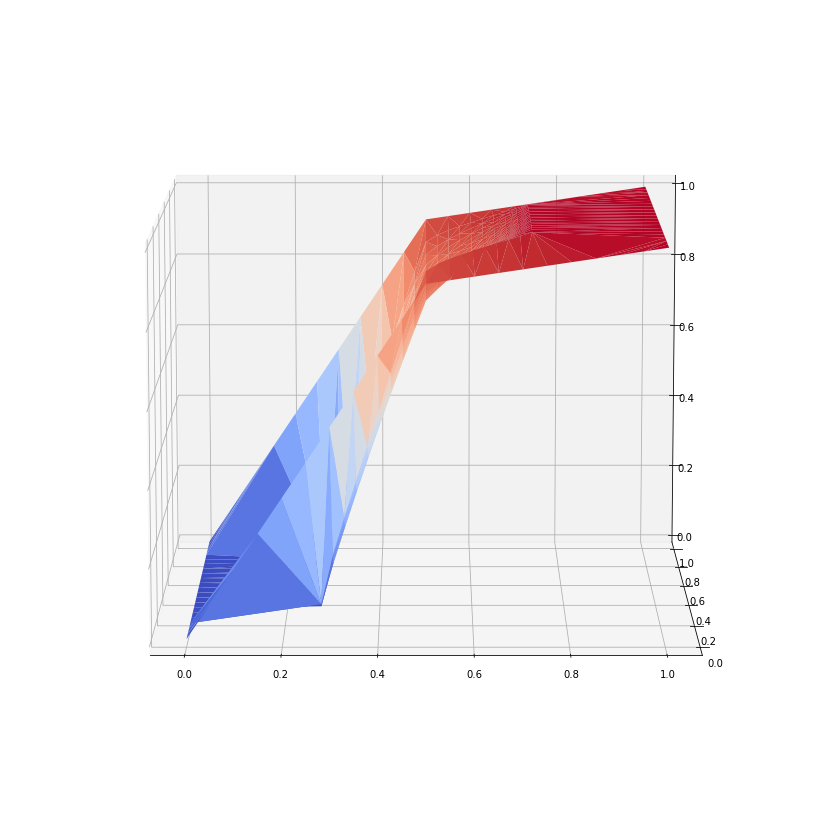

In [87]:
#visualization
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize = (15,15))
ax  = fig.add_subplot(111,projection='3d')
ax.azim = -90
ax.elev = 10.
surf = ax.plot_trisurf(nodes[:,0],nodes[:,1], u, cmap=cm.coolwarm)
plt.show()

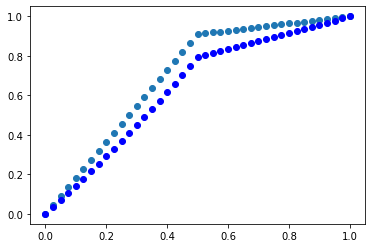

In [711]:
fig,ax = plt.subplots()
#ax.plot(nodes[bnd_marker==3,0], u[bnd_marker==3],'o')
ax.plot(nodes[bnd_marker==1,0], u[bnd_marker==1],'o')
ax.plot(nodes[820:861,0], u[820:861], 'bo')

In [15]:
M_T

array([[ 0.91666667,  0.25      , -0.41666667,  0.25      ],
       [ 0.41666667,  1.08333333,  0.41666667, -0.25      ],
       [-0.41666667,  0.25      ,  0.91666667,  0.25      ],
       [ 0.08333333, -0.58333333,  0.08333333,  0.75      ]])

In [16]:
print (np.dot(REC[80],np.array([1.,1.,1.,1.]) )   )
it

[1. 1. 1. 1.]


NameError: name 'it' is not defined

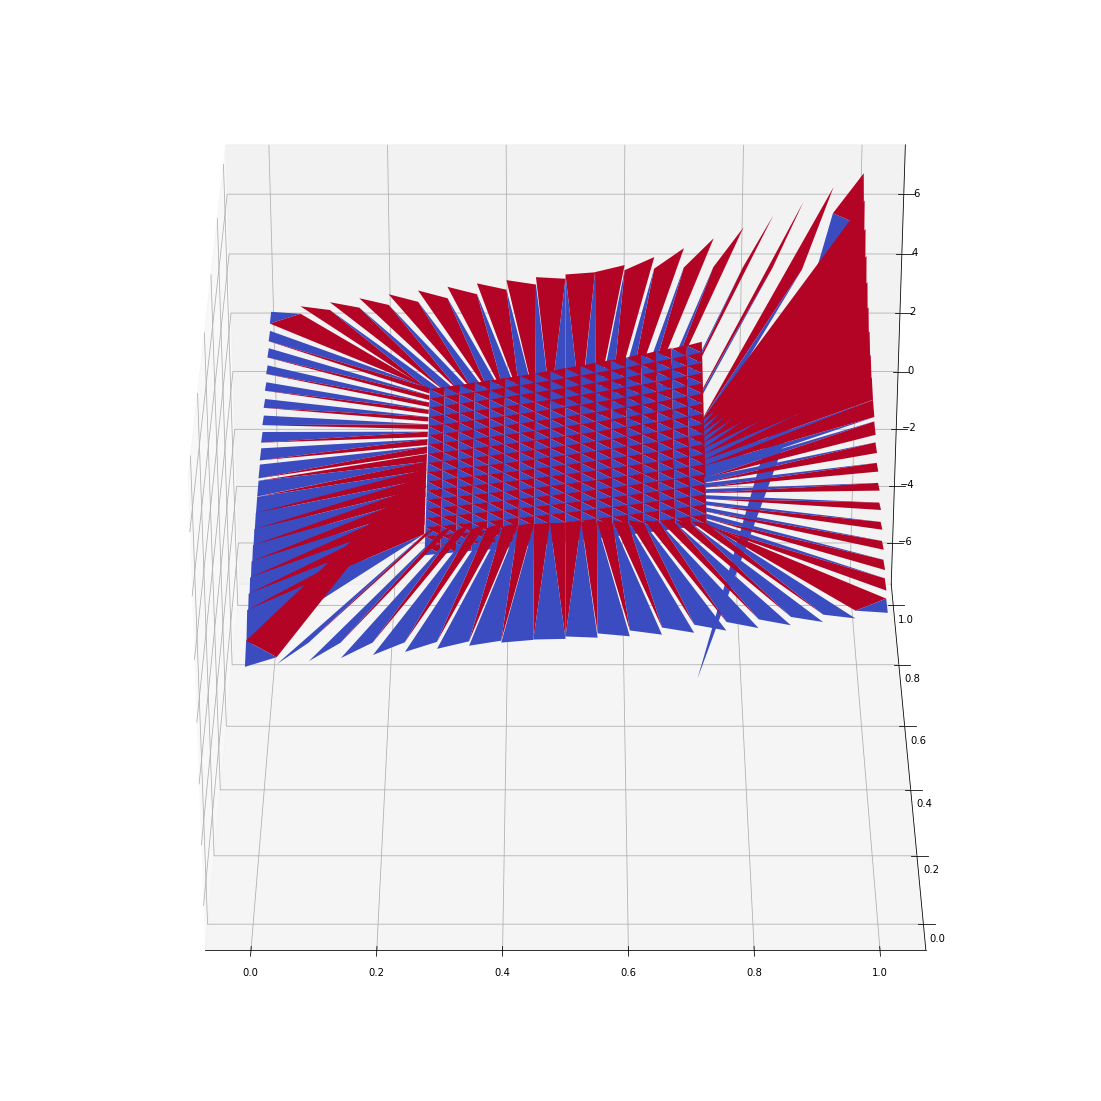

In [82]:
#try to assign a field of nodal values and look at how it is reconstructed
field = np.zeros(Nnodes)
for n in range(Nnodes):
    [x,y] = nodes[n]
    field[n] = np.exp(x)*np.exp(y)

fig = plt.figure(figsize = (20,20))
ax  = fig.add_subplot(111, projection='3d')
ax.azim = -90. 
ax.elev = 30.
for k in range(Nelements):
    xx = np.zeros(4)
    yy = np.zeros(4)
    nodal_values = np.zeros(4)
    for i in range(4):
        xx[i], yy[i] = nodes[elements[k][i]]
        nodal_values [i] = field[elements[k][i]]
    reconstruction = np.dot(REC[k],nodal_values) 
    surf = ax.plot_trisurf(xx,yy, reconstruction, cmap=cm.coolwarm)

In [23]:
np.linalg.solve(M,B)
np.dot(V, np.array([0.,0.,1.]))

array([-0.075,  0.075,  0.075, -0.075])

In [18]:
print (V)
print (M)
print (B)
print (np.linalg.solve(M,B))
print (np.linalg.solve(M,B)@np.array([1.,1.,1.,1.]))
print ((V@np.linalg.solve(M,B)).T@np.array([1.,2.,3.,2.]))

[[ 2.    -0.075 -0.075]
 [ 2.    -0.075  0.075]
 [ 2.     0.075  0.075]
 [ 2.     0.075 -0.075]]
[[ 1.00000000e-02 -7.18946507e-19 -7.28583860e-19]
 [-7.18946507e-19  4.68750000e-06  0.00000000e+00]
 [-7.28583860e-19  0.00000000e+00  4.68750000e-06]]
[[ 1.25000000e-03  1.25000000e-03  1.25000000e-03  1.25000000e-03]
 [-2.60416667e-05 -2.60416667e-05  1.56250000e-05  1.56250000e-05]
 [-1.56250000e-05  2.60416667e-05  2.60416667e-05 -1.56250000e-05]]
[[ 0.125       0.125       0.125       0.125     ]
 [-5.55555556 -5.55555556  3.33333333  3.33333333]
 [-3.33333333  5.55555556  5.55555556 -3.33333333]]
[ 0.5        -4.44444444  4.44444444]
[0.66666667 2.         3.33333333 2.        ]


In [15]:
REC [150]

array([[ 0.75,  0.25, -0.25,  0.25],
       [ 0.25,  0.75,  0.25, -0.25],
       [-0.25,  0.25,  0.75,  0.25],
       [ 0.25, -0.25,  0.25,  0.75]])

In [23]:
# gradient reconstruction
def GT (elem, nodal_values):
    #elem: element index
    #vector of nodal values
    g_T = np.array([0.,0.])
    for k in range(4):
        e_avg = -0.5*(normal[elem,k]+normal[elem, (k-1)%4])
        g_T = g_T + (1/m_T[elem])*e_avg*nodal_values[k]
    return g_T

print (GT(10,[1.,2.,3.,2.]))

[20. 20.]
